# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Change-point-analysis" data-toc-modified-id="Change-point-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Change point analysis</a></div>

In [1]:
import pyflux as pf
from spikeHelper.loadSpike import loadSpikeBehav
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spk, bhv = loadSpikeBehav('Data/rato8tudo.mat')
spikes = pd.DataFrame({i: pd.Series(np.unique(v)) for i,v in enumerate(spk.times.values)})

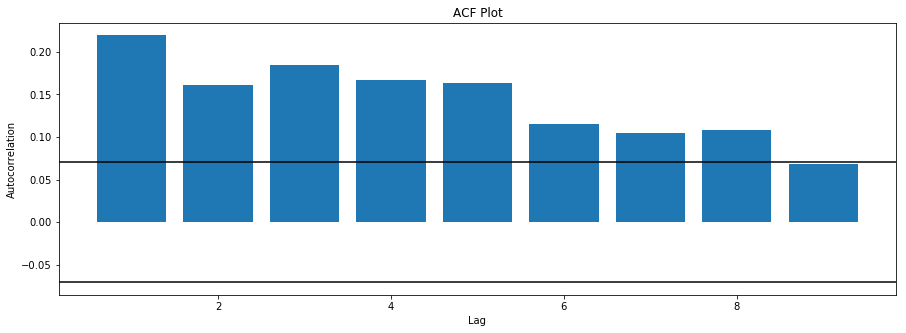

In [226]:
pf.acf_plot(bhv.duration.values)

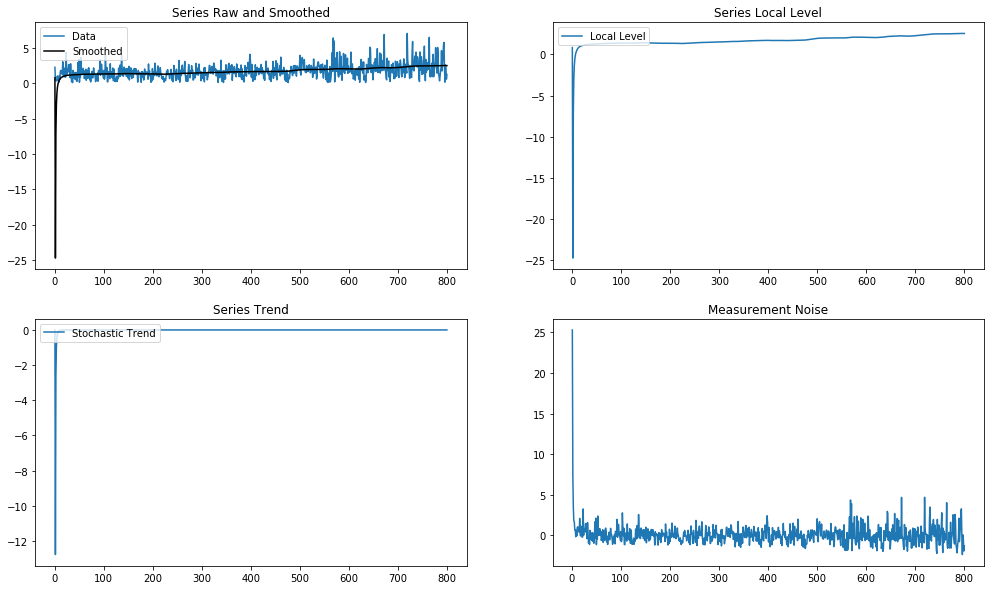

In [227]:
model = pf.LLT(data= bhv.duration.values)
model.fit()
model.plot_fit(intervals=False,figsize=(17,10))

In [228]:
bhv['reward'] = bhv['duration'] > 1.5
bhv['reward'] = bhv['reward'].apply(int)
bhv['last'] = np.r_[0, bhv.duration.values[:-1]]
bhv['lr'] = np.r_[0, bhv.reward.values[:-1]]
bhv['rewarded'] = np.r_[0, (bhv['duration']*bhv['reward']).values[:-1]]
bhv['nonrewarded'] = np.r_[0, (bhv['duration']*(1-bhv['reward'])).values[:-1]]

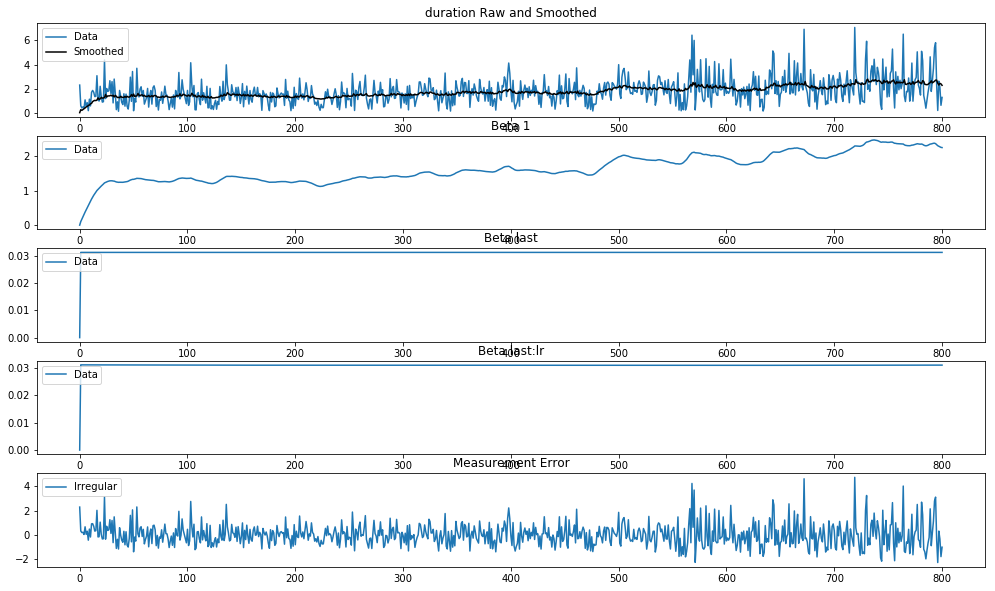

In [290]:
model = pf.DynamicGLM(data= bhv, formula = 'duration~1+last+last:lr',family=pf.Normal())
x = model.fit('MLE')
model.plot_fit(intervals=False,figsize=(17,10))

In [292]:
x.summary()

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: duration                            Method: MLE                                       
Start Date: 0                                           Log Likelihood: -1149.8814                        
End Date: 800                                           AIC: 2307.7629                                    
Number of observations: 801                             BIC: 2326.5063                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.9313                                                           
Sigma^2 1                            

# Change point analysis

In [16]:
def scoringTrial(duration, criterion=1.5):
    return 1-abs(np.log10(duration/criterion))

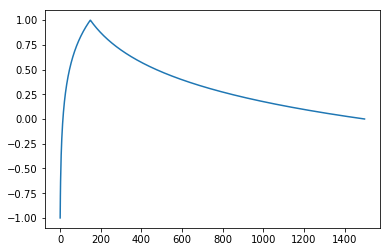

In [17]:
plt.plot(scoringTrial(np.arange(0.015,15,0.01)))

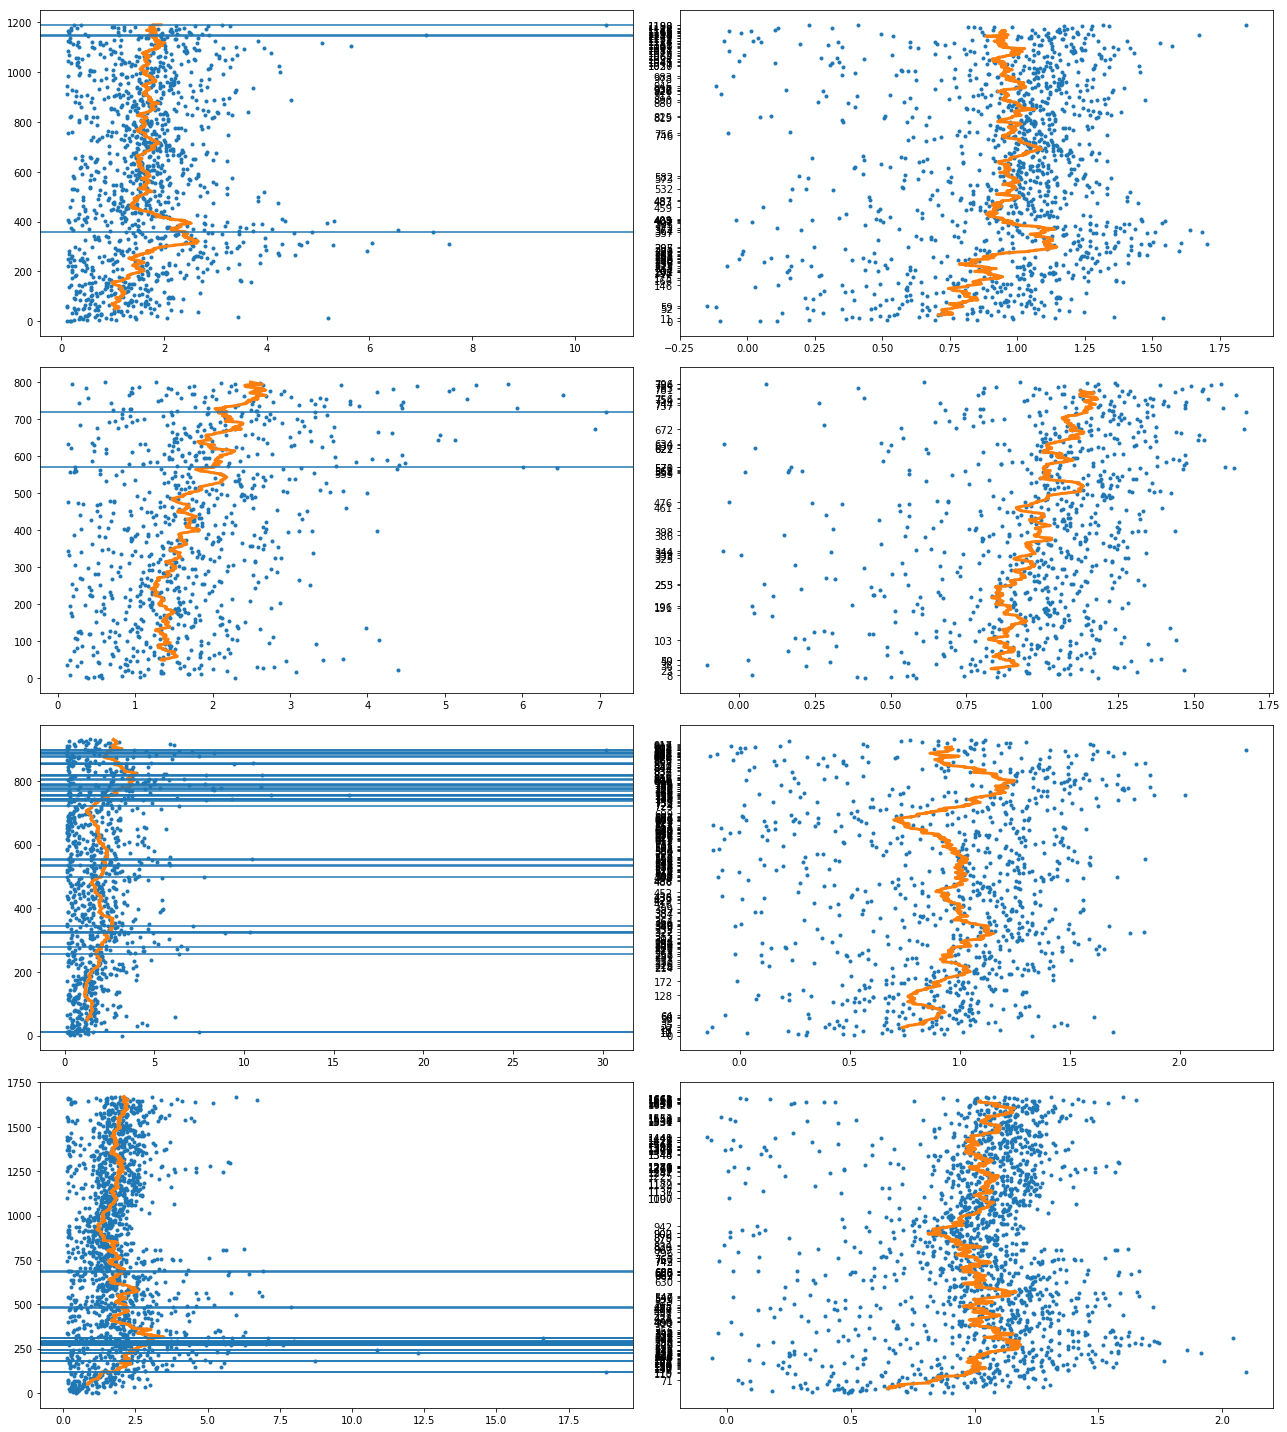

In [14]:
window= 50
plt.figure(figsize=(18,20))
for i, rat in enumerate([7,8,9,10]):
    spk, bhv = loadSpikeBehav('Data/rato'+str(rat)+'tudo.mat')
    plt.subplot(4,2,2*i+1)
    plt.plot(bhv.duration.values,np.arange(bhv.shape[0]),'.')
    plt.plot(bhv.duration.rolling(window).apply(np.mean).values,np.arange(bhv.shape[0]),linewidth=3)
    nT = 10; threshold = 1;
    #while nT > 5:
    #    threshold+=0.01
    alarm,idx,c,d=detect_cusum(bhv.duration.values,threshold=5,show=False,drift=.5,ending=True)
    #    nT = len(idx)
    [plt.axhline(ix) for ix in idx]
    plt.subplot(4,2,2*i+2)
    plt.plot(bhv.duration.apply(scoringTrial).values,np.arange(bhv.shape[0]),'.')
    plt.plot(bhv.duration.apply(scoringTrial).rolling(window,center=True).apply(np.mean).values,np.arange(bhv.shape[0]),linewidth=3)
    alarm,idx,c,d=detect_cusum(bhv.duration.apply(scoringTrial).values,threshold=1,show=False,drift=.02,ending=True)
    #[plt.axhline(ix) for ix in idx]
    plt.yticks(idx)
plt.tight_layout()

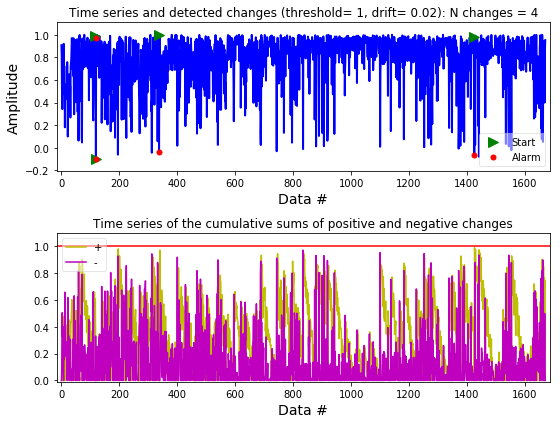

In [122]:
alarm,idx,c,d=detect_cusum(bhv.duration.apply(scoringTrial).values,threshold=1,drift=.02)

In [404]:
def singleRatBehaviorPlot(durations,tVec, threshold='max',Tc = 1.5,kde='fl',kdeN = 100):
    f = plt.figure(figsize=(14,14))
    sns.set_style("whitegrid")
    trialNumber = np.arange(len(durations))


    # Behavioral dots
    nonRewarded = (durations < Tc)
    plt.scatter(durations[nonRewarded],trialNumber[nonRewarded],color=(0.6, 0.036000000000000004, 0.0),s=80)#(0.48, 0.1416, 0.12))

    rewarded = (durations >= Tc)
    plt.scatter(durations[rewarded],trialNumber[rewarded],color=(0.0, 0.6, 0.18600000000000008),s=80)

    plt.ylim([0,len(durations)]);plt.xlim([0,5]); pcax = plt.gca()
    plt.ylabel('Trial number',fontsize=18); plt.xlabel('Time from nosepoke onset (s)',fontsize=18)


    # Changepoint lines
    if threshold == 'max':
        plt.axhline(np.argmax(tVec),linestyle='-.',linewidth=6,color='k')
    else:
        pass
        plt.hlines(np.nonzero(tVec>threshold)[0],0,max(durations),'k',linestyle='-.',linewidth=6)

    # Changepoint lateral
    cpax = f.add_axes([1,.045,0.1,.945])
    cpax.plot(tVec,trialNumber,'k'); plt.yticks([]);
    plt.ylim([0,len(durations)]); plt.xlabel('Odds',fontsize=16)

    # Kernel density
    kdax = f.add_axes([.06,1,.925,0.1])
    if kde in  ['fl','firstlast']:
        first = durations[:kdeN]
        last = durations[-kdeN:]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=2); 
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'magenta',linewidth=4); 
        plt.xticks([]); plt.xlim([0,5]);plt.ylim([0,0.8])
    
        pcax.axhline(kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(len(durations)-kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
    
    elif kde in ['cp','fromcp']:
        first = durations[np.argmax(tVec)-kdeN:np.argmax(tVec)]
        last = durations[np.argmax(tVec):np.argmax(tVec)+kdeN]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=2); 
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'magenta',linewidth=4); 
        plt.xticks([]); plt.xlim([0,5]);plt.ylim([0,0.8])
    
        pcax.axhline(np.argmax(tVec)-kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(np.argmax(tVec)+kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)

    
    plt.suptitle('Behavior evolution in one session',y = 1.14, fontsize=22, x=0.55)
    plt.tight_layout()


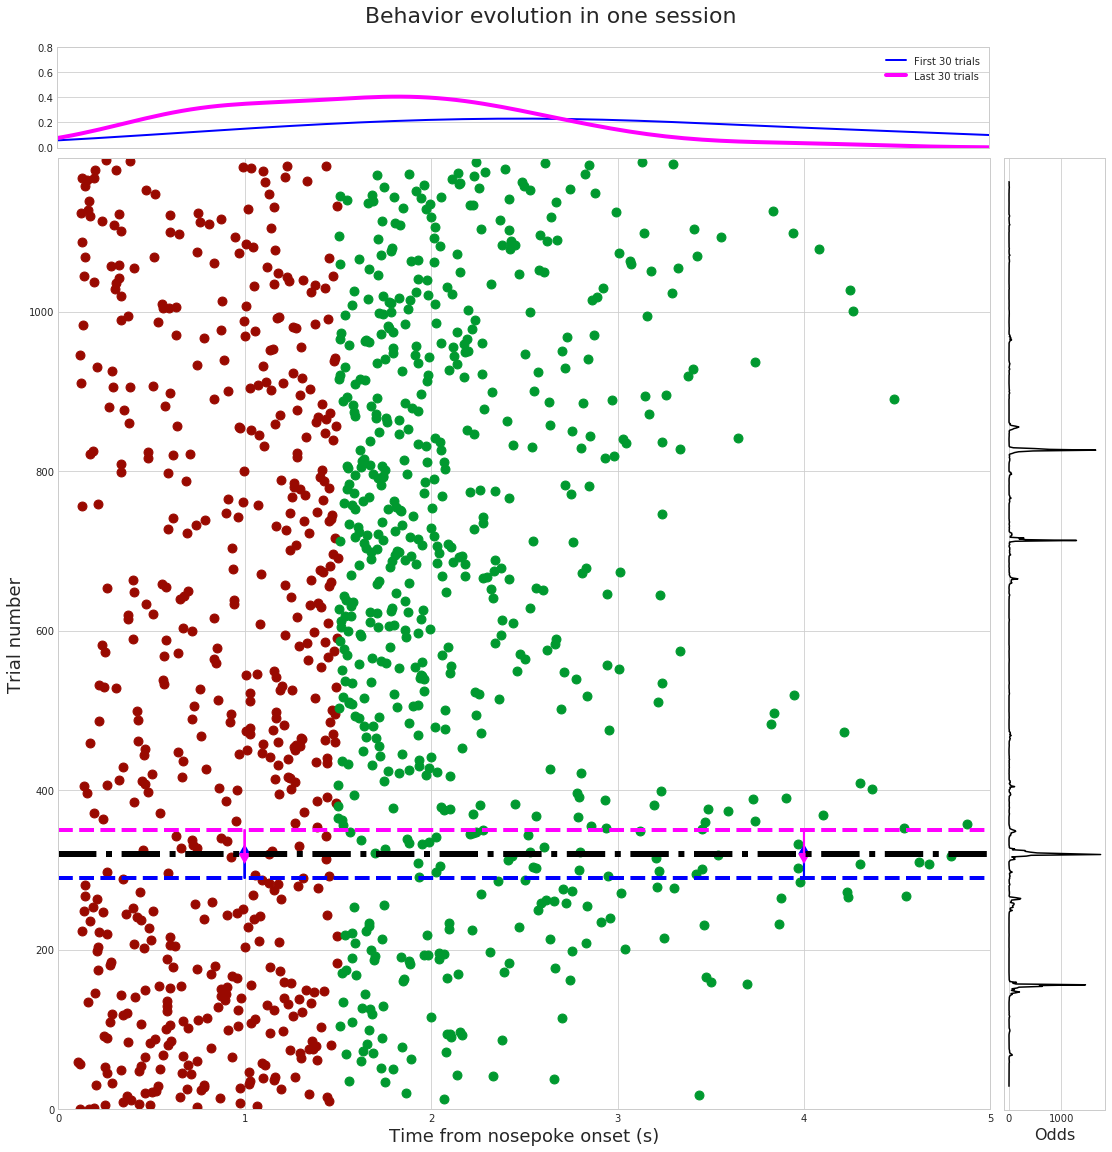

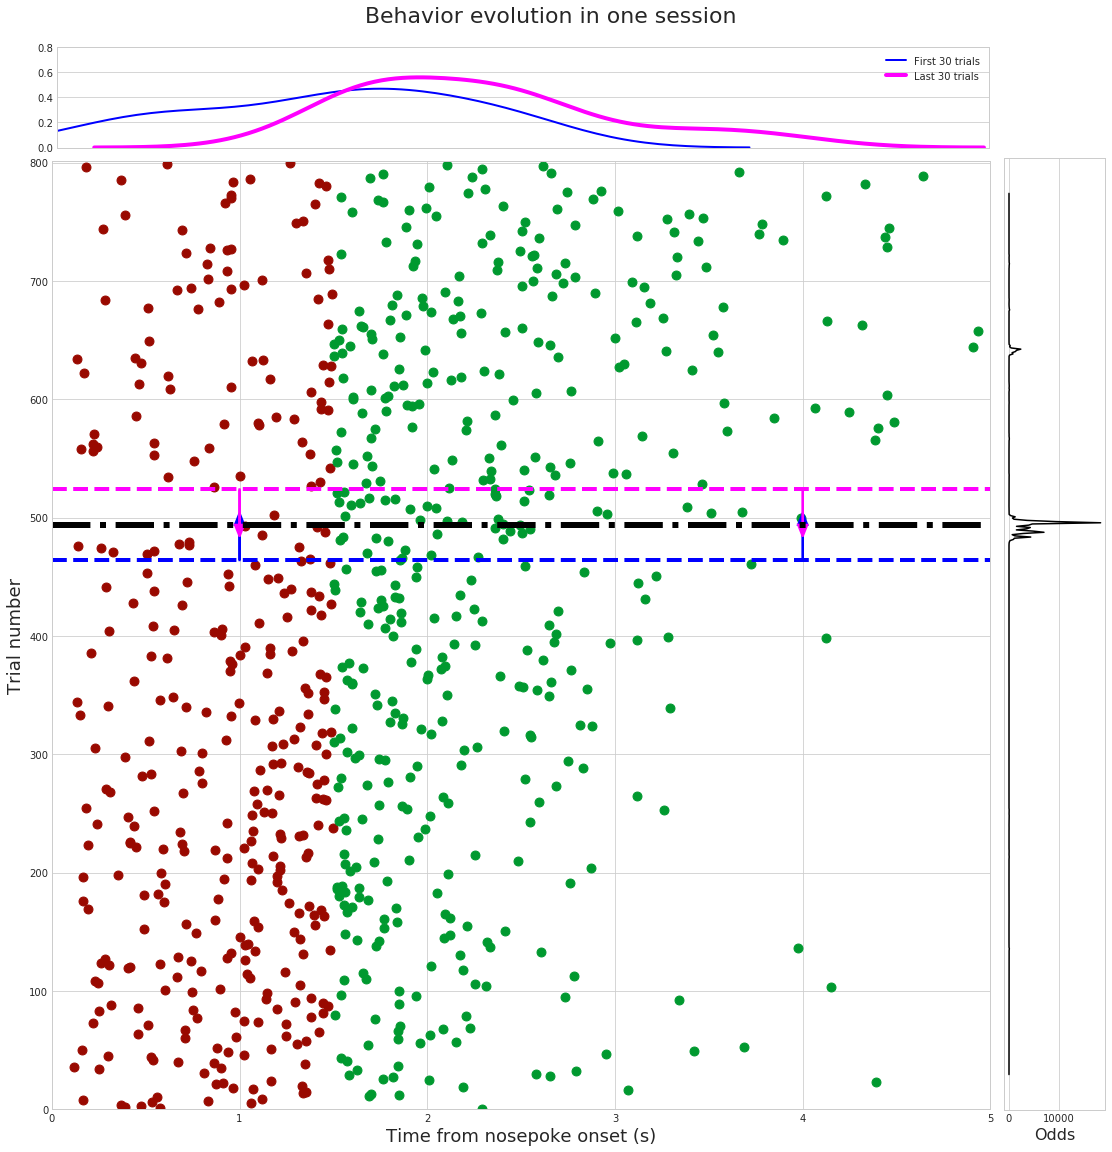

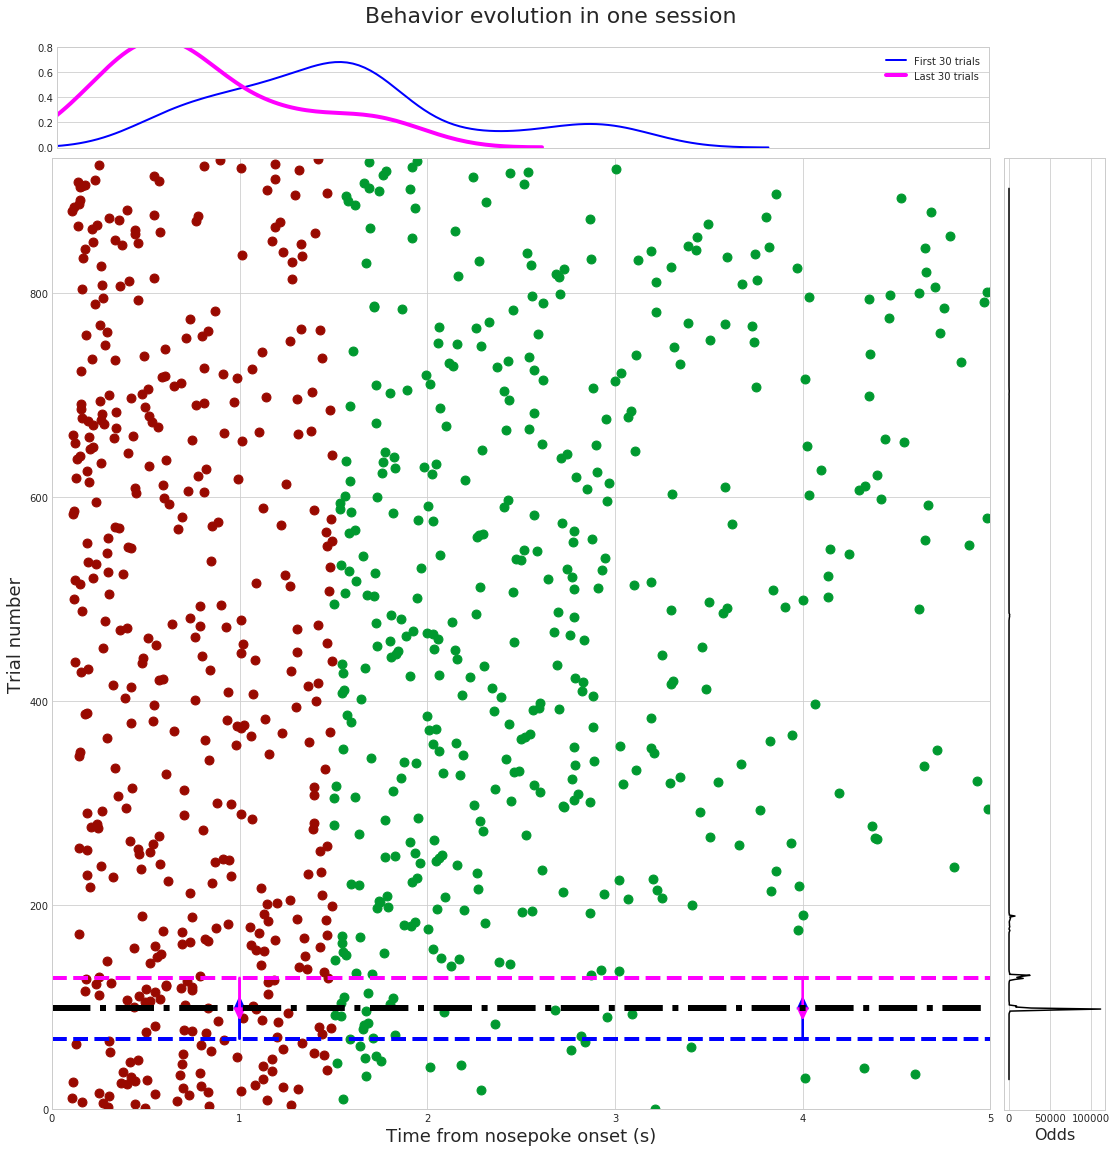

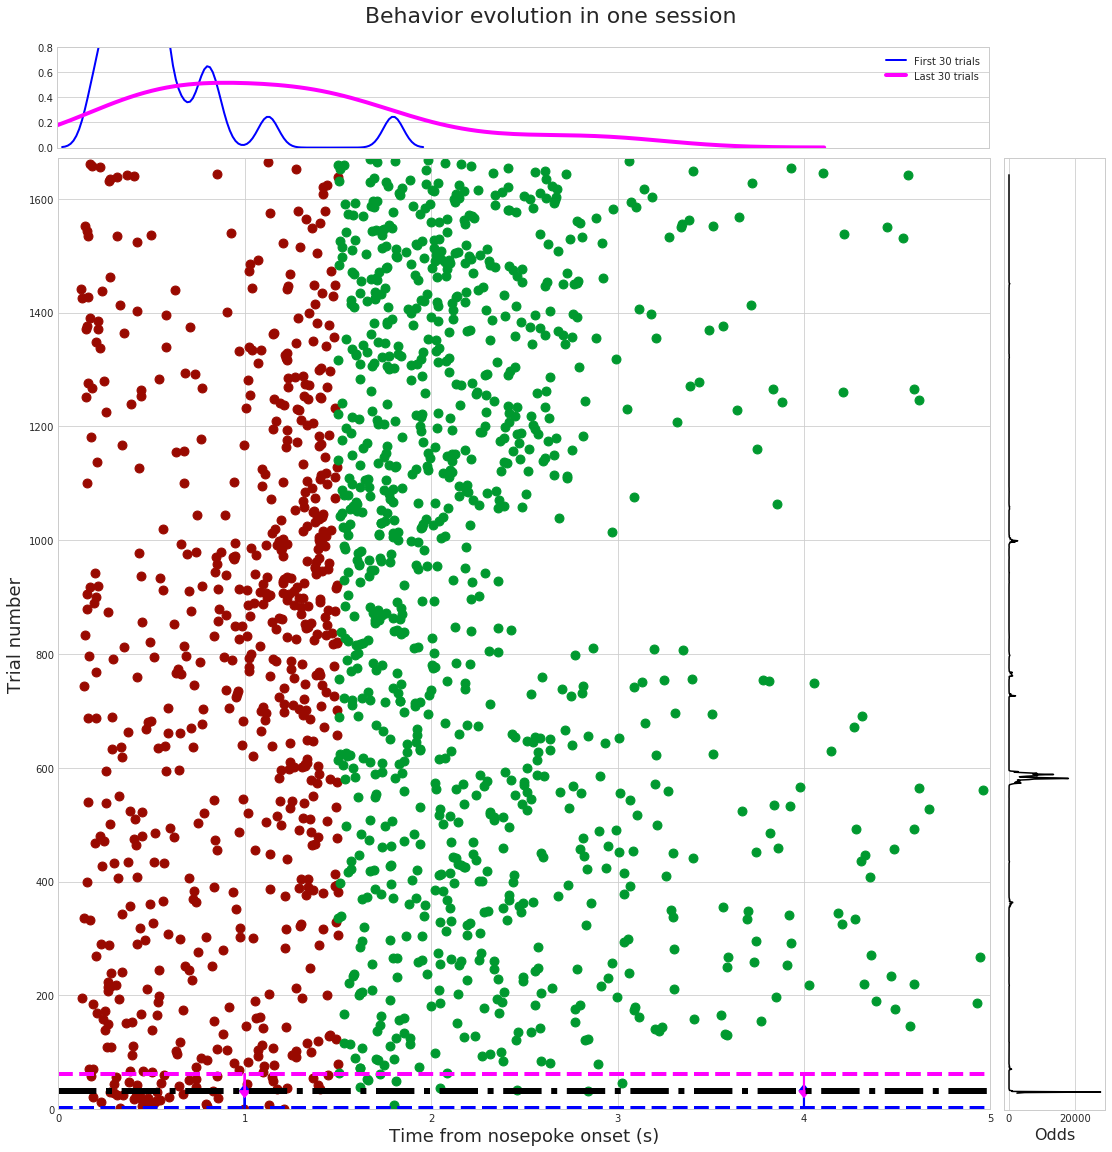

In [405]:
from scipy.io import loadmat
for i, rat in enumerate([7,8,9,10]):
    cps = loadmat('Data/alloddsr{}.mat'.format(rat))['allOdds'].ravel()
    spk, bhv = loadSpikeBehav('Data/rato'+str(rat)+'tudo.mat')
    cps = bhv.duration.rolling(60,center=True).apply(lambda x: odds(x[:30],x[30:]))
    singleRatBehaviorPlot(bhv.duration,cps,kde='cp',kdeN=30)

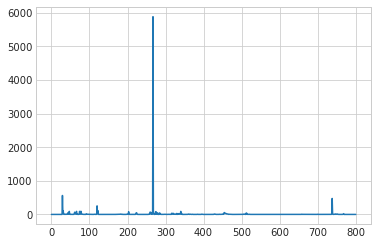

In [409]:
rat=8
plt.plot( loadmat('Data/alloddsr{}.mat'.format(rat))['allOdds'].ravel())

In [385]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind()

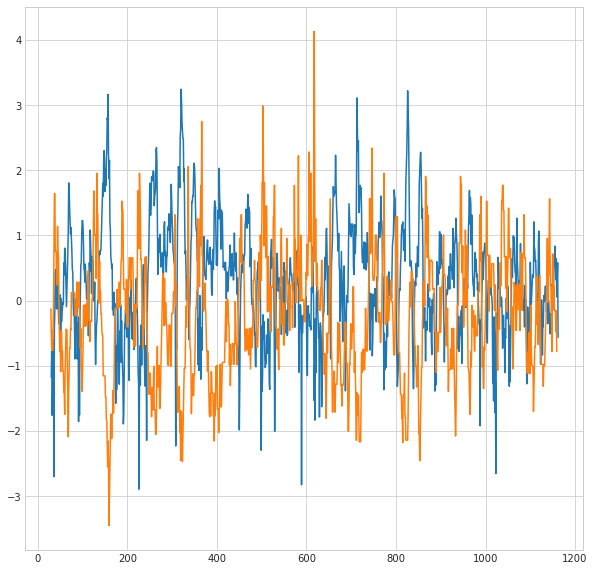

In [399]:
rat = 7
cps = loadmat('Data/alloddsr{}.mat'.format(rat))['allOdds'].ravel()
def odds(x,y):
    p = ttest_ind(x,y)[1]
    return (1-p)/p

f=plt.figure(figsize=(10,10))
spk, bhv = loadSpikeBehav('Data/rato'+str(rat)+'tudo.mat')
plt.plot()
plt.plot(np.log10(cps))

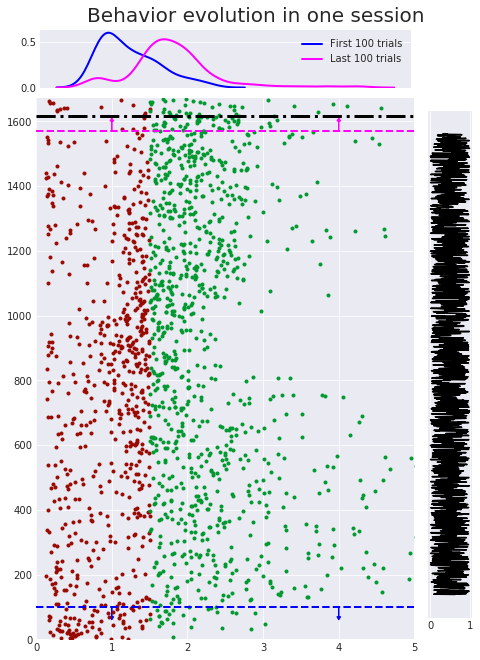

In [253]:
Tc = 1.5
threshold='max'
durations  = bhv.duration.values
tVec = np.random.rand(len(durations))
kde='fl'


f = plt.figure(figsize=(6,8))
sns.set_style('darkgrid')
trialNumber = np.arange(len(durations))


# Behavioral dots
nonRewarded = (durations < Tc)
plt.plot(durations[nonRewarded],trialNumber[nonRewarded],'.',color=(0.6, 0.036000000000000004, 0.0))#(0.48, 0.1416, 0.12))

rewarded = (durations >= Tc)
plt.plot(durations[rewarded],trialNumber[rewarded],'.',color=(0.0, 0.6, 0.18600000000000008))

plt.ylim([0,len(durations)]);plt.xlim([0,5]); pcax = plt.gca()



# Changepoint lines
if threshold == 'max':
    plt.axhline(np.argmax(tVec),linestyle='-.',linewidth=3,color='k')
else:
    pass
    plt.hlines(np.nonzero(tVec>threshold)[0],0,max(durations),'k',linestyle='-.',linewidth=3)
    
# Changepoint lateral
cpax = f.add_axes([1,.08,0.1,.88])
cpax.plot(tVec,trialNumber,'k'); plt.yticks([]);






# Kernel density
kdax = f.add_axes([.1,1,.86,0.1])
if kde in  ['fl','firstlast']:
    first = durations[:100]
    last = durations[-100:]

    sns.kdeplot(first,label='First 100 trials',color='b',linewidth=2); 
    sns.kdeplot(last, label = 'Last 100 trials',color = 'magenta',linewidth=2); 
    plt.xticks([])
    
    pcax.axhline(100,linestyle='--',color='b',linewidth=2);
    pcax.arrow(1,100,0,-30, head_width=0.05, head_length=10, fc='b', ec='b')
    pcax.arrow(4,100,0,-30, head_width=0.05, head_length=10, fc='b', ec='b')
    
    pcax.axhline(len(durations)-100,linestyle='--',color = 'magenta',linewidth=2)
    pcax.arrow(1,len(durations)-100,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta')
    pcax.arrow(4,len(durations)-100,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta')
    
plt.suptitle('Behavior evolution in one session',y = 1.14, fontsize=20, x=0.6)
plt.tight_layout()


#cpax.invert_xaxis()

In [244]:
colors = sns.hls_palette(8, l=.3, s=1)

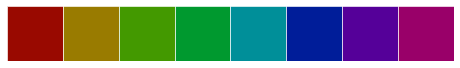

In [245]:
sns.palplot(colors)

In [246]:
colors

[(0.6, 0.036000000000000004, 0.0),
 (0.6, 0.48599999999999999, 0.0),
 (0.26400000000000012, 0.6, 0.0),
 (0.0, 0.6, 0.18600000000000008),
 (0.0, 0.56399999999999983, 0.6),
 (0.0, 0.11399999999999982, 0.6),
 (0.33599999999999974, 0.0, 0.6),
 (0.6, 0.0, 0.41399999999999954)]

In [126]:
np.nonzero(tVec>threshold)

(array([  19,   53,   57,   58,   89,   94,  136,  233,  266,  314,  331,
         408,  443,  455,  475,  491,  512,  540,  569,  584,  623,  639,
         642,  646,  682,  758,  816,  817,  852,  868,  894,  900,  929,
         964,  968,  977, 1005, 1024, 1027, 1038, 1047, 1072, 1103, 1117,
        1132, 1139, 1150, 1155, 1174, 1193, 1195, 1302, 1331, 1356, 1371,
        1417, 1448, 1450, 1487, 1509, 1594, 1618, 1634, 1649, 1670]),)

In [103]:
?plt.Line2D.set_linestyle

In [41]:
import seaborn as sns

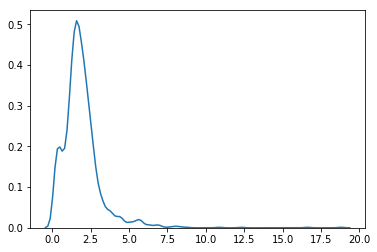

In [44]:
sns.kdeplot(durations)

In [12]:
import numpy as np

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.
    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).
    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.
    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.
    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.
    See this IPython Notebook [2]_.
    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb
    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)
    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)
    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()